In [1]:
import pandas as pd
import numpy as np

In [2]:
try:
    df = pd.read_csv('data/raw.csv',low_memory=False) 
    print(f"Data loaded successfully. Initial rows: {len(df)}")
except FileNotFoundError:
    print("ERROR: Please ensure 'data/raw.csv' is in the correct directory.")
    exit()

Data loaded successfully. Initial rows: 374362


In [3]:
list(df.columns)

['add_these_pw_job_title_9089',
 'agent_city',
 'agent_firm_name',
 'agent_state',
 'application_type',
 'case_no',
 'case_number',
 'case_received_date',
 'case_status',
 'class_of_admission',
 'country_of_citizenship',
 'country_of_citzenship',
 'decision_date',
 'employer_address_1',
 'employer_address_2',
 'employer_city',
 'employer_country',
 'employer_decl_info_title',
 'employer_name',
 'employer_num_employees',
 'employer_phone',
 'employer_phone_ext',
 'employer_postal_code',
 'employer_state',
 'employer_yr_estab',
 'foreign_worker_info_alt_edu_experience',
 'foreign_worker_info_birth_country',
 'foreign_worker_info_city',
 'foreign_worker_info_education',
 'foreign_worker_info_education_other',
 'foreign_worker_info_inst',
 'foreign_worker_info_major',
 'foreign_worker_info_postal_code',
 'foreign_worker_info_rel_occup_exp',
 'foreign_worker_info_req_experience',
 'foreign_worker_info_state',
 'foreign_worker_info_training_comp',
 'foreign_worker_ownership_interest',
 'fore

In [4]:
relevant_columns = [
    'case_received_date', 
    'decision_date', 
    'case_status',
    'class_of_admission',      
    'country_of_citizenship',  
    'job_info_job_title',      
    'pw_amount_9089',         
    'pw_level_9089',         
    'employer_state',          
    'employer_city',           
    'naics_us_title',         
    'job_info_education',    
    'job_info_experience'    
]
df = df[relevant_columns].copy()
df.rename(columns={
    'job_info_job_title': 'job_title',
    'pw_amount_9089': 'prevailing_wage',
    'pw_level_9089': 'wage_level',
    'naics_us_title': 'industry',
    'job_info_education': 'education_level'
}, inplace=True)

In [5]:
df.head()

,case_received_date,decision_date,case_status,class_of_admission,country_of_citizenship,job_title,prevailing_wage,wage_level,employer_state,employer_city,industry,education_level,job_info_experience
0,NaN,2012-02-01,Certified,J-1,NaN,NaN,75629.0,Level II,NY,NEW YORK,NaN,NaN,NaN
1,NaN,2011-12-21,Denied,B-2,NaN,NaN,37024.0,Level I,NY,CARLSTADT,NaN,NaN,NaN
2,NaN,2011-12-01,Certified,H-1B,NaN,NaN,47923.0,Level I,VA,GLEN ALLEN,NaN,NaN,NaN
3,NaN,2011-12-01,Certified,B-2,NaN,NaN,10.97,Level II,NY,FLUSHING,NaN,NaN,NaN
4,NaN,2012-01-26,Certified,L-1,NaN,NaN,94890.0,Level IV,NY,ALBANY,NaN,NaN,NaN


# Generating Target Variables

In [6]:
df['case_received_date'] = pd.to_datetime(df['case_received_date'])
df['decision_date'] = pd.to_datetime(df['decision_date'])

In [7]:
df['processing_time_days'] = (df['decision_date'] - df['case_received_date']).dt.days

In [8]:
initial_rows = len(df)
df = df[df['processing_time_days'] > 0].copy()
print(f"Removed {initial_rows - len(df)} rows with invalid processing time.")
print(f"Target variable 'processing_time_days' created.")

Removed 137447 rows with invalid processing time.
Target variable 'processing_time_days' created.


# Feature Engineering and Encoding

## Handing Missing Values

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 236915 entries, 135269 to 374357
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   case_received_date      236915 non-null  datetime64[ns]
 1   decision_date           236915 non-null  datetime64[ns]
 2   case_status             236915 non-null  object        
 3   class_of_admission      221075 non-null  object        
 4   country_of_citizenship  236881 non-null  object        
 5   job_title               236873 non-null  object        
 6   prevailing_wage         236782 non-null  object        
 7   wage_level              220943 non-null  object        
 8   employer_state          236890 non-null  object        
 9   employer_city           236909 non-null  object        
 10  industry                148875 non-null  object        
 11  education_level         214464 non-null  object        
 12  job_info_experience     236905

In [10]:
df['prevailing_wage']=df['prevailing_wage'].str.replace(',','').astype(float)
median_wage = df['prevailing_wage'].median()
df['prevailing_wage']=df['prevailing_wage'].fillna(median_wage)
print(f"Filled missing 'prevailing_wage' with median: {median_wage}")

Filled missing 'prevailing_wage' with median: 86195.0


In [11]:
cat_cols = ['class_of_admission', 'country_of_citizenship', 'job_title', 
            'employer_state', 'employer_city', 'industry', 
            'wage_level', 'education_level']

for col in cat_cols:
    df[col]=df[col].fillna('Missing')

In [12]:
df['job_info_experience']=df['job_info_experience'].fillna('N')

## Encoding

In [13]:
wage_map = {'Level I': 1, 'Level II': 2, 'Level III': 3, 'Level IV': 4, 'Missing': 0}
df['wage_level_encoded'] = df['wage_level'].map(wage_map)
df['experience_required_encoded'] = df['job_info_experience'].map({'Y': 1, 'N': 0})

In [14]:
def clean_education(edu):
    edu = str(edu).lower()
    if 'master' in edu: return 'Master'
    if 'bachelor' in edu: return 'Bachelor'
    if 'doctorate' in edu or 'phd' in edu: return 'Doctorate'
    if 'none' in edu: return 'None'
    return 'Other'

df['education_cleaned'] = df['education_level'].apply(clean_education)
edu_map = {'None': 0, 'Other': 1, 'Bachelor': 2, 'Master': 3, 'Doctorate': 4}
df['education_encoded'] = df['education_cleaned'].map(edu_map)

In [15]:
def group_top_n(dataframe, col, n=20):
    top_items = dataframe[col].value_counts().nlargest(n).index
    return np.where(dataframe[col].isin(top_items), dataframe[col], 'Other')

df['industry_grouped'] = group_top_n(df, 'industry', 15)
df['city_grouped'] = group_top_n(df, 'employer_city', 20)
df['job_grouped'] = group_top_n(df, 'job_title', 20)
df['country_grouped'] = group_top_n(df, 'country_of_citizenship', 15)

In [16]:
cols_to_encode = ['class_of_admission', 'industry_grouped', 'city_grouped', 
                  'job_grouped', 'country_grouped', 'employer_state', 'case_status']
encoded_features = pd.get_dummies(df[cols_to_encode], drop_first=True)

In [17]:
final_df = pd.concat([
    df[['processing_time_days', 'prevailing_wage', 'wage_level_encoded', 
        'experience_required_encoded', 'education_encoded']],
    encoded_features
], axis=1)
print(f"Final Data Shape: {final_df.shape}")
print(f"Target Column: 'processing_time_days'")
print(f"Feature Columns (First 5): {final_df.columns[:5].tolist()}")

Final Data Shape: (236915, 241)
Target Column: 'processing_time_days'
Feature Columns (First 5): ['processing_time_days', 'prevailing_wage', 'wage_level_encoded', 'experience_required_encoded', 'education_encoded']


In [18]:
final_df.to_csv('data/preprocessed.csv', index=False)
print("Data saved to 'data/preprocessed.csv'")

Data saved to 'data/preprocessed.csv'


# Exploratory Data Analysis

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

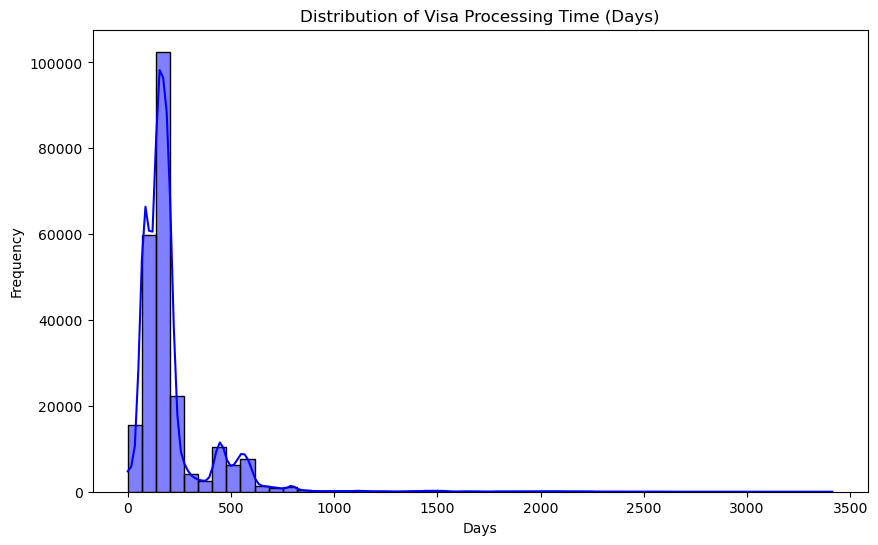

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(df['processing_time_days'], kde=True, bins=50, color='blue')
plt.title('Distribution of Visa Processing Time (Days)')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.show()

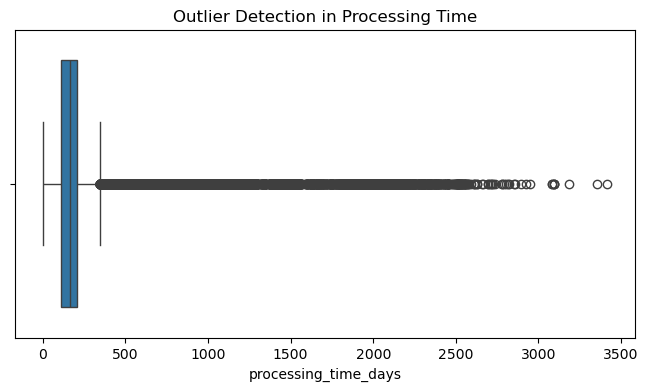

In [21]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['processing_time_days'])
plt.title('Outlier Detection in Processing Time')
plt.show()

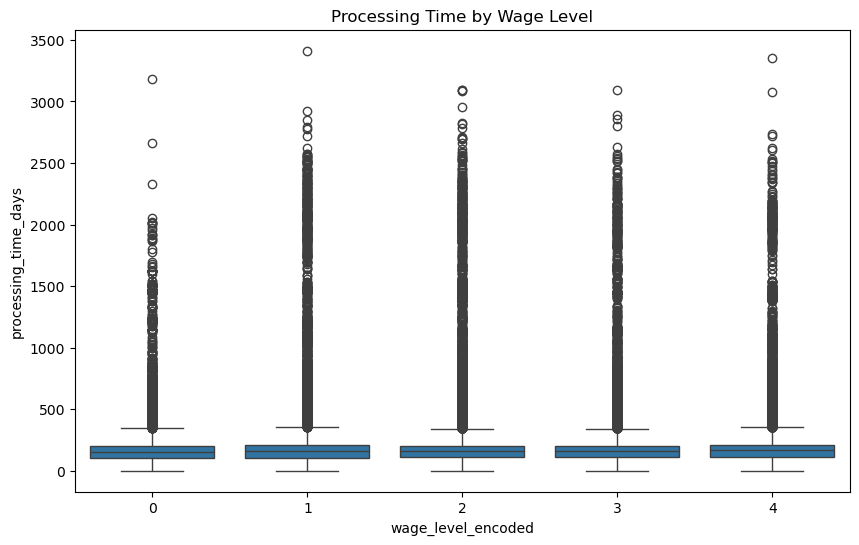

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='wage_level_encoded', y='processing_time_days', data=df)
plt.title('Processing Time by Wage Level')
plt.show()

In [23]:
Q1 = df['processing_time_days'].quantile(0.25)
Q3 = df['processing_time_days'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['processing_time_days'] < lower_bound) | (df['processing_time_days'] > upper_bound)]
print(f"Total Outliers detected: {len(outliers)}")
print(f"Percentage of data as outliers: {len(outliers)/len(df)*100:.2f}%")

Total Outliers detected: 32703
Percentage of data as outliers: 13.80%


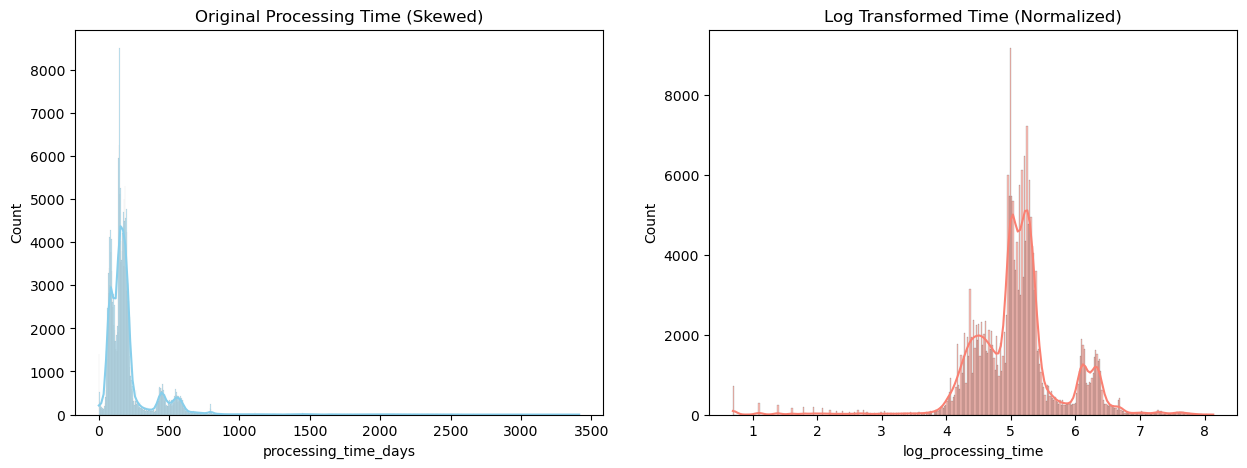

In [24]:
df['log_processing_time'] = np.log1p(df['processing_time_days'])
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df['processing_time_days'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Original Processing Time (Skewed)')
sns.histplot(df['log_processing_time'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Log Transformed Time (Normalized)')
plt.show()

C:\Users\Divya\AppData\Local\Temp\ipykernel_12984\2184556853.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_of_admission', y='processing_time_days', data=df_filtered, palette='viridis')


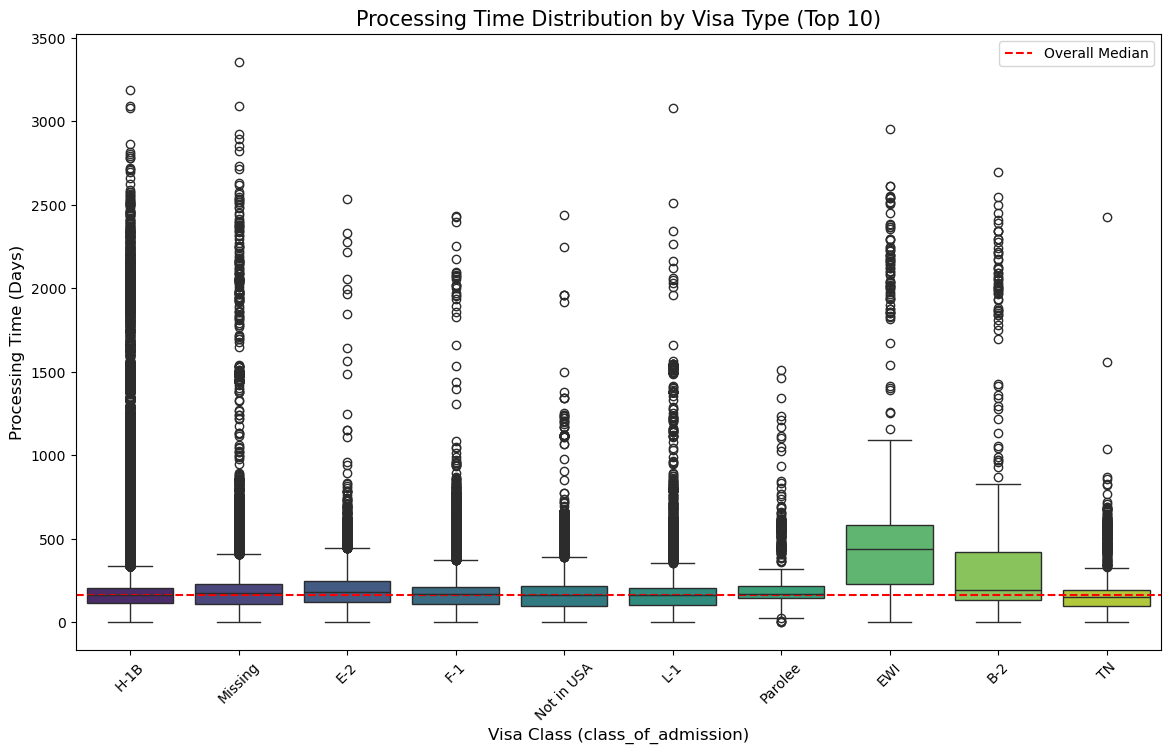

In [25]:
top_visa_types = df['class_of_admission'].value_counts().nlargest(10).index
df_filtered = df[df['class_of_admission'].isin(top_visa_types)]
plt.figure(figsize=(14, 8))
sns.boxplot(x='class_of_admission', y='processing_time_days', data=df_filtered, palette='viridis')
plt.axhline(df['processing_time_days'].median(), color='red', linestyle='--', label='Overall Median')
plt.title('Processing Time Distribution by Visa Type (Top 10)', fontsize=15)
plt.xlabel('Visa Class (class_of_admission)', fontsize=12)
plt.ylabel('Processing Time (Days)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [26]:
df[df['class_of_admission']=='EWI'].count()

case_received_date             953
decision_date                  953
case_status                    953
class_of_admission             953
country_of_citizenship         953
job_title                      953
prevailing_wage                953
wage_level                     953
employer_state                 953
employer_city                  953
industry                       953
education_level                953
job_info_experience            953
processing_time_days           953
wage_level_encoded             953
experience_required_encoded    953
education_cleaned              953
education_encoded              953
industry_grouped               953
city_grouped                   953
job_grouped                    953
country_grouped                953
log_processing_time            953
dtype: int64

In [27]:
visa_stats = df.groupby('class_of_admission')['processing_time_days'].agg(['median', 'count', 'std'])
print(visa_stats.sort_values(by='median', ascending=False))

                    median   count         std
class_of_admission                            
EWI                  440.0     953  501.912905
A-3                  436.0      17  580.194877
Q                    252.5       4  114.950714
H-2B                 226.0     267  389.167127
VWT                  210.0      36  494.103668
P-3                  209.0      33  338.232121
C-3                  204.0       5  150.300699
D-1                  204.0       4  151.274585
G-5                  204.0      37  246.678159
K-1                  199.0       1         NaN
H-2A                 198.0      95  316.013241
O-2                  197.0      15  122.426577
M-1                  196.0      17  170.982799
P-4                  196.0       4   52.639497
B-2                  192.5    2086  340.295415
F-2                  188.0     697  239.870591
P-1                  187.0     131  338.169400
VWB                  185.5       6  349.508464
G-1                  182.5       8  143.025472
I            

## Correlations

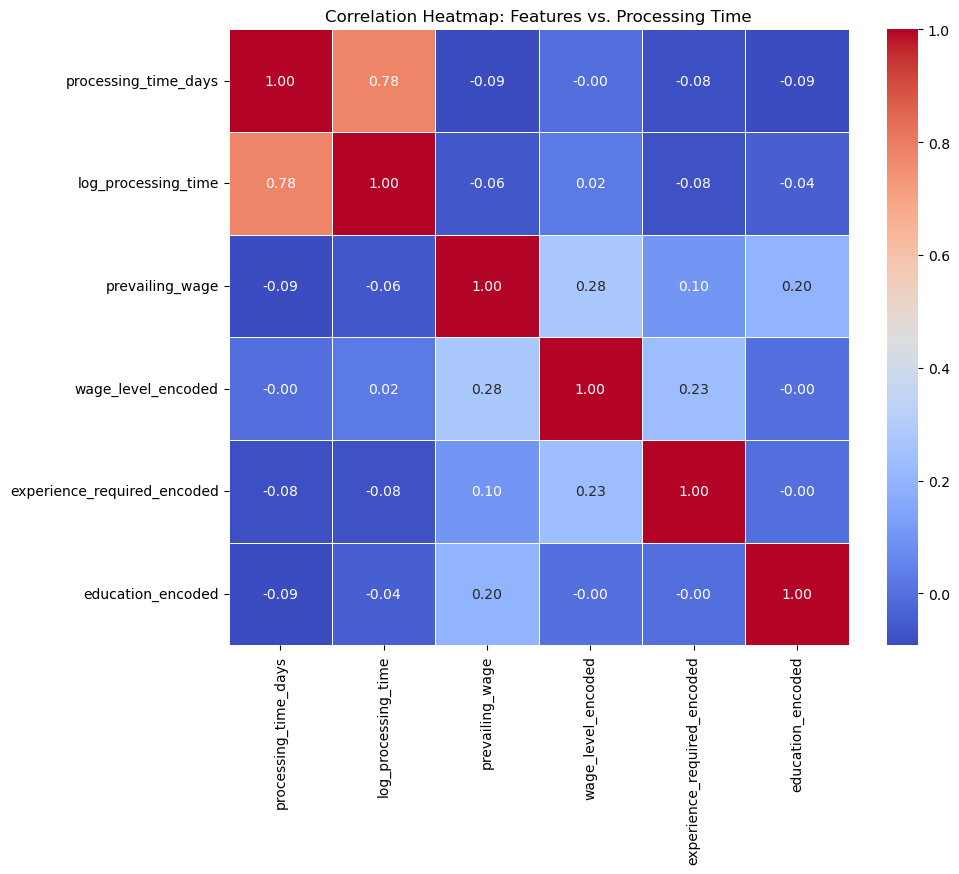

In [28]:
cols_for_corr = [
    'processing_time_days', 
    'log_processing_time',
    'prevailing_wage', 
    'wage_level_encoded', 
    'experience_required_encoded', 
    'education_encoded'
]
corr_matrix = df[cols_for_corr].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap: Features vs. Processing Time')
plt.show()

## Features

In [35]:
df['app_month'] = df['case_received_date'].dt.month
df['app_quarter'] = df['case_received_date'].dt.quarter
global_mean = df['processing_time_days'].mean()
month_means = df.groupby('app_month')['processing_time_days'].mean()
seasonal_idx_map = (month_means / global_mean).to_dict()
df['seasonal_index'] = df['app_month'].map(seasonal_idx_map)
country_avg_map = df.groupby('country_grouped')['processing_time_days'].mean().to_dict()
df['country_avg_days'] = df['country_grouped'].map(country_avg_map)
print("Engineered Features: 'seasonal_index' and 'country_avg_days' added.")

Engineered Features: 'seasonal_index' and 'country_avg_days' added.


C:\Users\Divya\AppData\Local\Temp\ipykernel_12984\533296693.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='app_month', y='seasonal_index', data=df, palette='coolwarm')


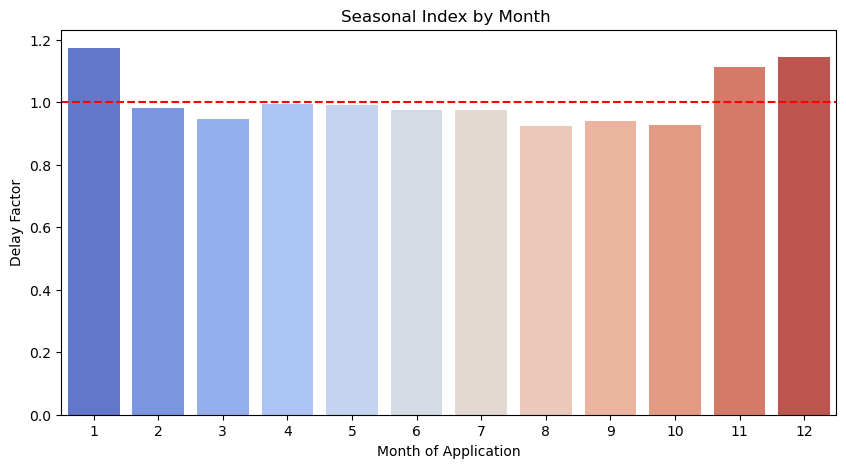

In [38]:
plt.figure(figsize=(10, 5))
sns.barplot(x='app_month', y='seasonal_index', data=df, palette='coolwarm')
plt.axhline(1, color='red', linestyle='--') # The average baseline
plt.title('Seasonal Index by Month ')
plt.ylabel('Delay Factor')
plt.xlabel('Month of Application')
plt.show()

In [42]:
visa_avg = df.groupby("class_of_admission")["processing_time_days"].mean()
df["visa_avg"] = df["class_of_admission"].map(visa_avg)
industry_avg = df.groupby("industry")["processing_time_days"].mean()
df["industry_avg"] = df["industry"].map(industry_avg)
job_avg = df.groupby("job_title")["processing_time_days"].mean()
df["job_avg"] = df["job_title"].map(job_avg)
print("Features added: 'Visa-Type Averages', 'Industry type average', 'Job Tile Average'")

Features added: 'Visa-Type Averages', 'Industry type average', 'Job Tile Average'


In [44]:
df.head()

,case_received_date,decision_date,case_status,class_of_admission,country_of_citizenship,job_title,prevailing_wage,wage_level,employer_state,employer_city,...,job_grouped,country_grouped,log_processing_time,app_month,app_quarter,seasonal_index,country_avg_days,visa_avg,industry_avg,job_avg
135269,2013-11-19,2015-05-29,Certified,H-1B,INDIA,Senior Engineer,83366.0,Level IV,WISCONSIN,WAUKESHA,...,Other,INDIA,6.322565,11,4,1.112429,205.591503,205.529553,280.479339,175.453642
135270,2013-11-12,2015-06-26,Denied,Missing,SOUTH KOREA,Catfish Processor,16973.0,Level I,MISSISSIPPI,ITTA BENA,...,Other,SOUTH KOREA,6.383507,11,4,1.112429,222.184786,238.102020,280.479339,452.162338
135271,2013-11-27,2014-10-16,Denied,H-1B,GERMANY,Protein Production Scientist,49982.0,Level I,COLORADO,AURORA,...,Other,Other,5.780744,11,4,1.112429,215.672287,205.529553,280.479339,323.000000
135272,2013-11-13,2015-05-26,Certified,E-2,SOUTH KOREA,Market Research Analyst,43514.0,Level I,WASHINGTON,LYNNWOOD,...,Other,SOUTH KOREA,6.327937,11,4,1.112429,222.184786,234.681929,280.479339,237.462932
135273,2013-11-12,2015-06-26,Denied,Missing,SOUTH KOREA,Catfish Processor,16973.0,Level I,MISSISSIPPI,ITTA BENA,...,Other,SOUTH KOREA,6.383507,11,4,1.112429,222.184786,238.102020,280.479339,452.162338
